In [1]:
import os
import sys
sys.path.append("..")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']= '1`'
os.environ['LIBRARY_PATH'] = '/usr/local/cuda/lib64'

In [1]:
#from model import YModel
#from gan import Generator, Discriminator, WSDiscriminator, GANLosses
# from metrics import Metrics
# from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)
#device = torch.device("cpu")


In [2]:
#from comet_ml import API
import comet_ml

%matplotlib inline

my_cmap = plt.cm.jet
my_cmap.set_under('white')

In [3]:
from collections import defaultdict
comet_api = comet_ml.papi.API()
comet_api.get()

['shir994']

In [11]:
exp_metrics = {}
exp = comet_api.get("shir994/2d-convergence/98be17738135460fab35ab23d555a22c")
metrics_vals = exp.get_metrics()
for metric in exp.get_metrics_summary():
    exp_metrics[metric["name"]] = np.array([float(m["metricValue"]) for m in metrics_vals if m["metricName"] == metric["name"]])

In [15]:
exp_metrics["train_loss"]

array([1.41728938, 0.72014517, 1.05420959, 1.02527535, 0.99532491,
       0.97020584, 0.94904947, 1.07120323, 0.78042197, 0.76571566,
       0.75133318, 0.73900634, 0.72727209, 1.37378347, 0.63470447,
       0.62753701, 0.61825514, 0.60969442, 0.60192013, 1.58451211,
       0.54390848, 0.53795618, 0.53517604, 0.52940989, 0.52055138,
       1.73042572, 0.48113185, 0.47444278, 0.47192594, 0.46546692,
       0.46184763, 1.84619641, 0.42241859, 0.41559571, 0.42056337,
       0.40976188, 0.41086602, 1.93885326, 0.37780714, 0.37602681,
       0.37685603, 0.36580026, 0.36694402, 2.06684995, 0.34692231,
       0.34312811, 0.3353942 , 0.34241545, 0.33830193, 2.16556215,
       0.31018215, 0.31537122, 0.31329092, 0.30863714, 0.31675911,
       2.26085901, 0.29777679, 0.2951138 , 0.28821665, 0.28858709,
       0.29051176, 2.31832337, 0.29529735, 0.28639099, 0.28892908,
       0.2850858 , 0.28480771, 2.38280106, 0.28552595, 0.28466785,
       0.29151914, 0.29396373, 0.30346394, 2.42430305, 0.30026

In [43]:
exp.get_metrics_summary()

[{'name': 'train_average_mu_JS',
  'valueMax': '0.6340621122717858',
  'valueMin': '0.472655450552702',
  'valueCurrent': '0.49533665999770166',
  'timestampMax': 1559657128545,
  'timestampMin': 1559657128545,
  'timestampCurrent': 1559659063603,
  'runContextMax': 'train',
  'runContextMin': 'train',
  'runContextCurrent': 'train',
  'stepMax': 19,
  'stepMin': 379,
  'stepCurrent': 999},
 {'name': 'train_average_mu_KS',
  'valueMax': '0.9106899999999999',
  'valueMin': '0.7009449999999999',
  'valueCurrent': '0.7455549999999999',
  'timestampMax': 1559657128545,
  'timestampMin': 1559657128545,
  'timestampCurrent': 1559659063603,
  'runContextMax': 'train',
  'runContextMin': 'train',
  'runContextCurrent': 'train',
  'stepMax': 19,
  'stepMin': 379,
  'stepCurrent': 999},
 {'name': 'train_data_diff_order_1',
  'valueMax': '7.486870288848877',
  'valueMin': '-0.044705867767333984',
  'valueCurrent': '0.08027362823486328',
  'timestampMax': 1559657085617,
  'timestampMin': 155965708

In [53]:
def extract_metrics(exp, hyper_params, metrics, mask):
    metrics_vals = exp.get_metrics()
    for metric in exp.get_metrics_summary():
        print(metric)
        #metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metric_values = np.array([float(m["metricValue"]) for m in metrics_vals if m["metricName"] == metric["name"]])
        metrics[metric["name"]].append([metric_values, hyper_params['data_size']])

In [40]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(1000))

In [56]:
metrics["10_5"]

defaultdict(list,
            {'train_average_mu_JS': [[array([0.63406211, 0.63387808, 0.62817774, 0.62560364, 0.59015649,
                      0.60692006, 0.57987663, 0.55897744, 0.55778448, 0.56382001,
                      0.51855561, 0.52060702, 0.53261647, 0.52134398, 0.5278595 ,
                      0.51622253, 0.51511223, 0.51223898, 0.47265545, 0.49875987,
                      0.48517756, 0.49579614, 0.52158521, 0.48874698, 0.51888325,
                      0.48513891, 0.50145678, 0.49258812, 0.51432926, 0.50906916,
                      0.50701074, 0.51981601, 0.53289649, 0.50735116, 0.51216988,
                      0.51174293, 0.49484596, 0.50907528, 0.49436436, 0.49238228,
                      0.51676928, 0.50973972, 0.53260286, 0.52395678, 0.51072744,
                      0.51255617, 0.50397965, 0.51411695, 0.51690174, 0.49533666]),
               '10']],
             'train_average_mu_KS': [[array([0.91069 , 0.895725, 0.89762 , 0.893455, 0.86668 , 0.8892  ,
         

In [55]:
metrics = defaultdict(lambda : defaultdict(list))
for experiment in comet_api.get("shir994/2d-convergence"):
    print(experiment)
    hyper_params = {}
    for param in experiment.get_parameters_summary():
        hyper_params[param["name"]] = param["valueMin"]
    if hyper_params['num_epochs'] == '1000' and\
       hyper_params['TASK'] == '5' and\
       ['1000_iter', '20size'] == experiment.get_tags():
        extract_metrics(experiment, hyper_params, metrics[hyper_params['data_size'] + "_" + hyper_params['TASK']], mask)

<APIExperiment 'shir994/2d-convergence/275a65622cca4f8dbbc976382e28bab5'>
<APIExperiment 'shir994/2d-convergence/c2b649100395464d94cbb252287778f0'>
<APIExperiment 'shir994/2d-convergence/02fcabeda308426697b512993858aeb3'>
<APIExperiment 'shir994/2d-convergence/11fa85e17167427bbf123048ab75b47f'>
<APIExperiment 'shir994/2d-convergence/1e0aa439ea80427cbdd4518952ee31e7'>
<APIExperiment 'shir994/2d-convergence/8fa2c634e4524c0e86545569c6144e27'>
<APIExperiment 'shir994/2d-convergence/dfa2bda46b7a4859aa73d4d06f783ad9'>
<APIExperiment 'shir994/2d-convergence/13964b7b63524e9dbe91d2012ccf7885'>
<APIExperiment 'shir994/2d-convergence/a98180adfcbd47b2b0564760fb593a46'>
<APIExperiment 'shir994/2d-convergence/bca1d3fe48484b1f881dca2e60c53236'>
<APIExperiment 'shir994/2d-convergence/5b1429fc55ae4312ad99a77dbb3c16c4'>
<APIExperiment 'shir994/2d-convergence/98be17738135460fab35ab23d555a22c'>
{'name': 'train_average_mu_JS', 'valueMax': '0.6340621122717858', 'valueMin': '0.472655450552702', 'valueCurrent

# GAN convergence

In [8]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')
plt.figure(figsize=(24,30))
index = 0
for metric in experiment.data['metrics']:
    if metric == "train_loss" or metric.startswith("train_data_gen"):
        continue
    plt.subplot(3,3, index + 1)
    index += 1
    
    data = []
    sizes = []
    iterations = []
    for key in metrics:
        data.append(metrics[key][metric][0][0])
        sizes.append([int(metrics[key][metric][0][1])] * metrics[key][metric][0][0].shape[0])
        iterations.append(np.arange(0, metrics[key][metric][0][0].shape[0]))
    
    if "average" in metric:
        metric = "val_" + "_".join(metric.split("_")[1:])
        iterations = np.array(iterations) * 20
        
    plt.scatter(iterations, np.array(sizes), c=data, cmap=my_cmap);#, norm=colors.LogNorm());
    plt.colorbar()
    plt.yscale("log")
    plt.title(metric, fontsize=15)
    plt.xlabel("iteration", fontsize=15)
    ax = plt.gca()
    ax.tick_params("both", labelsize=19)
    plt.ylabel("data_size", fontsize=19)



NameError: name 'experiment' is not defined

<Figure size 1728x2160 with 0 Axes>

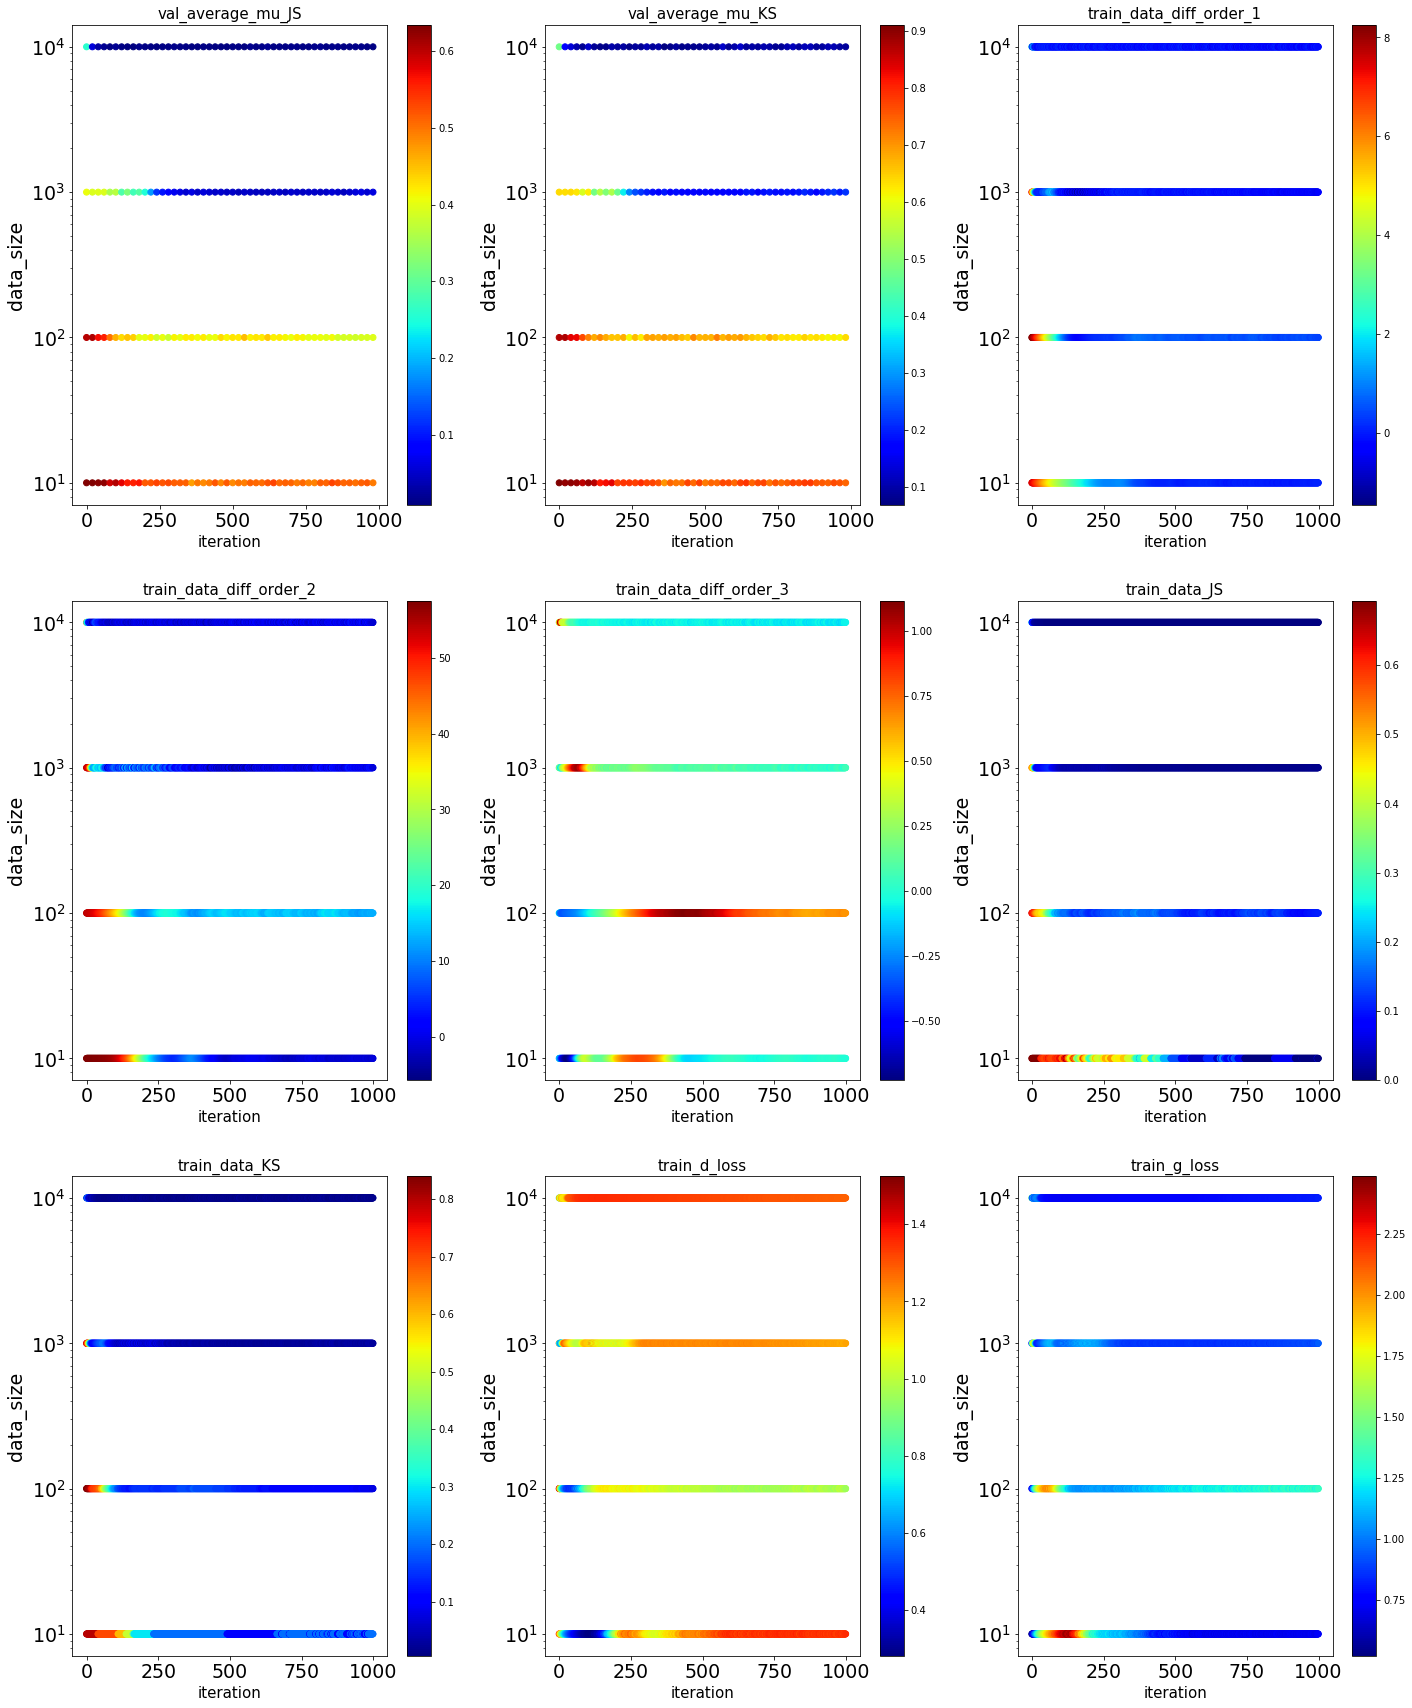

In [13]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')
plt.figure(figsize=(24,30))
index = 0
for metric in experiment.data['metrics']:
    if metric == "train_loss" or metric.startswith("train_data_gen"):
        continue
    plt.subplot(3,3, index + 1)
    index += 1
    
    data = []
    sizes = []
    iterations = []
    for key in metrics:
        data.append(metrics[key][metric][0][0])
        sizes.append([int(metrics[key][metric][0][1])] * metrics[key][metric][0][0].shape[0])
        iterations.append(np.arange(0, metrics[key][metric][0][0].shape[0]))
    
    if "average" in metric:
        metric = "val_" + "_".join(metric.split("_")[1:])
        iterations = np.array(iterations) * 20
        
    plt.scatter(iterations, np.array(sizes), c=data, cmap=my_cmap);#, norm=colors.LogNorm());
    plt.colorbar()
    plt.yscale("log")
    plt.title(metric, fontsize=15)
    plt.xlabel("iteration", fontsize=15)
    ax = plt.gca()
    ax.tick_params("both", labelsize=19)
    plt.ylabel("data_size", fontsize=19)


In [9]:
import pyro
from pyro import distributions as dist
from pyro import poutine
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100, input_param=2):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, z, params):
        """
            Generator takes a vector of noise and produces sample
        """
        #z = torch.cat([z, params.repeat(z.shape[0], 1)], dim=1)
        z = torch.cat([z, params], dim=1)
        h1 = torch.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100, input_param=2):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)

    def forward(self, x, params):
        #x = torch.cat([x, params.repeat(x.shape[0], 1)], dim=1)
        x = torch.cat([x, params], dim=1)
        h1 = torch.tanh(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        #h3 = F.leaky_relu(self.fc3(h2))
        score = torch.sigmoid(self.fc4(h2))
        return score    
class YModel(object):
    def __init__(self, x_range=(-10,10), init_mu=torch.tensor(0.)):
        self.mu_dist = dist.Delta(init_mu)
        self.x_dist = dist.Uniform(*x_range)
        #self.x_dist = dist.Delta(torch.tensor(float(0)))
    @staticmethod
    def f(x, a=0, b=1, c=2):
        return a + b * x
    @staticmethod
    def g(x, d=2):
        #return -7 + x ** 2 / 10 + x ** 3 / 100
        #return d * torch.sin(x)
        return torch.sqrt(torch.sum(x ** 2, dim=1, keepdim=True))
        #return x
    
    def std_val(self, x):
        return 0.1 + torch.abs(x) * 0.5
    
    def sample(self, sample_size=1):
        mu = pyro.sample('mu', self.mu_dist, torch.Size([sample_size]))
        if mu.size() == torch.Size([]):
            size = [1]
        else:
            size = mu.size()
        X = pyro.sample('X', self.x_dist, torch.Size(size))

        latent_x = pyro.sample('latent_x', dist.Normal(X, 1))
        latent_x = self.f(latent_x)

        latent_mu = self.g(mu)
        return pyro.sample('y', dist.Normal(latent_x + latent_mu, self.std_val(latent_x)))
        #return pyro.sample('y', dist.Normal(latent_x, 1)).float()
        #return pyro.sample('y', dist.Normal(latent_x, self.std_val(latent_x))).float()
    
    def make_condition_sample(self, data):
        self.condition_sample = poutine.condition(self.sample, data=data)
    
    def condition_sample(self, size=1):
        return self.condition_sample(size)    
class OptLoss(object):
    def __init__(self):
        pass
    
    @staticmethod
    def R(ys: torch.tensor, Y_0=-5):
        return (ys - Y_0).pow(2).mean(dim=1)
    @staticmethod
    def SigmoidLoss(ys: torch.tensor, left_bound, right_bound):
        return -torch.mean(torch.sigmoid(ys - left_bound) - torch.sigmoid(ys - right_bound), dim=1)
    
def sample_noise(N, NOISE_DIM):
    return np.random.uniform(size=(N,NOISE_DIM)).astype(np.float32)    

In [10]:
generators = {}
for exp in comet_api.get("shir994/2d-convergence"):
    hyper_params = {}
    for param in exp.get_parameters_summary():
        hyper_params[param["name"]] = param["valueMin"]
    if hyper_params['num_epochs'] != '1000' or\
       hyper_params['TASK'] != '5' or\
       ['1000_iter', '20size'] != exp.get_tags():
        continue
    
    TASK = int(hyper_params['TASK'])
    NOISE_DIM = int(hyper_params["NOISE_DIM"])    

    generator = Generator(NOISE_DIM, out_dim = 1, input_param=3).to(device)
    if TASK == 4:
        discriminator = WSDiscriminator(in_dim=1).to(device)
    else:
        discriminator = Discriminator(in_dim=1, input_param=3).to(device) 

    import io

    asset_id = [exp_a['assetId'] for exp_a in exp.get_asset_list() if exp_a['fileName'] ==
                "980.tar"][0]
    params = exp.get_asset(asset_id)
    state_dict = torch.load(io.BytesIO(params), map_location=device)
    generator.load_state_dict(state_dict['gen_state_dict'])
    generators[hyper_params['data_size'] + "_" + hyper_params['TASK']] = generator

In [11]:
from itertools import product
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
mu = torch.tensor(np.array(list(product(x,y)))).float()
y_sampler = YModel()

noise_size = 1000

In [12]:
%%time

y_surf = {}
for key in generators:
    y_mean = np.zeros([len(mu), 1])
    for i in range(len(mu)):
        noise = torch.Tensor(sample_noise(noise_size, NOISE_DIM)).to(device)
        mu_r = mu[i, :].reshape(1,-1).repeat(noise_size, 1).to(device)
        x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
        y_mean[i, 0] = generators[key](noise, torch.cat([mu_r,x_r],dim=1)).mean().item()
    y_surf[key] = y_mean

CPU times: user 2min 25s, sys: 2.15 s, total: 2min 27s
Wall time: 2min 27s


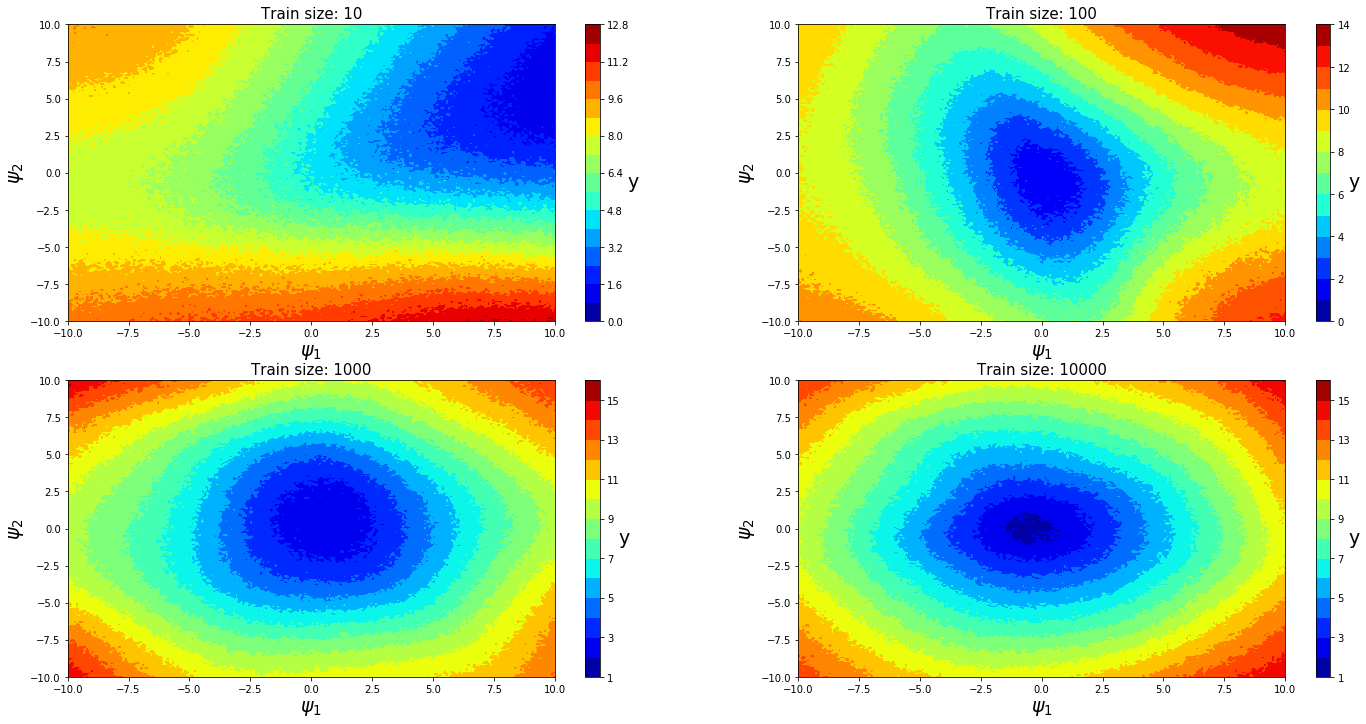

In [12]:
plt.figure(figsize=(24, 12))
for index, key in enumerate(y_surf):
    plt.subplot(2,2, index + 1)
    plt.contourf(*np.meshgrid(x,y), y_surf[key].reshape(-1, x.shape[0]).T, cmap=my_cmap, levels=15)
    plt.title(f"Train size: {key.split('_')[0]}", fontsize=15)
    cbar = plt.colorbar()
    plt.xlabel(f"$\psi_1$", fontsize=19)
    plt.ylabel(f"$\psi_2$", fontsize=19)
    cbar.set_label('y', rotation=0, fontsize=19)
plt.savefig("plots/y_surface_as_train.pdf", bbox_inches='tight')

# Optimisation procedure

In [37]:
#from model import OptLoss

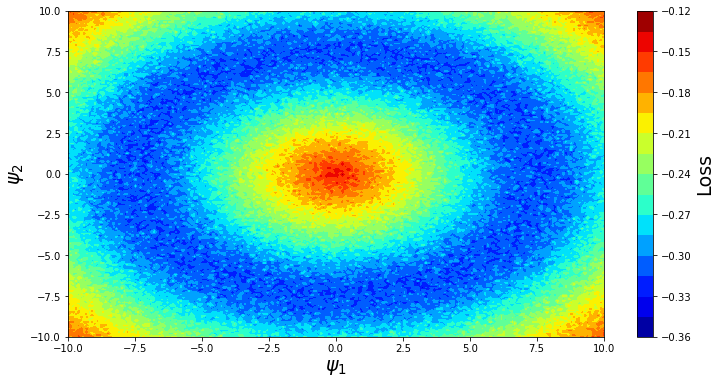

In [16]:
import numpy as np
plt.figure(figsize=(12,6))
#mu = dist.Uniform(-10,10).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

#plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
plt.contourf(*np.meshgrid(x,y), torch.transpose(rs.reshape(-1, x.shape[0]), 1,0), cmap=my_cmap, levels=15)

cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

In [14]:
%%time

loss_surf = {}
for key in generators:
    loss_val = np.zeros([len(mu), 1])
    for i in range(len(mu)):
        noise = torch.Tensor(sample_noise(noise_size, NOISE_DIM)).to(device)
        mu_r = mu[i, :].reshape(1,-1).repeat(noise_size, 1).to(device)
        x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
        samples = generators[key](noise, torch.cat([mu_r,x_r],dim=1))
        loss_val[i, 0] = OptLoss.SigmoidLoss(samples, 5, 10).mean().item()
    loss_surf[key] = loss_val

CPU times: user 2min 54s, sys: 2.55 s, total: 2min 57s
Wall time: 2min 57s


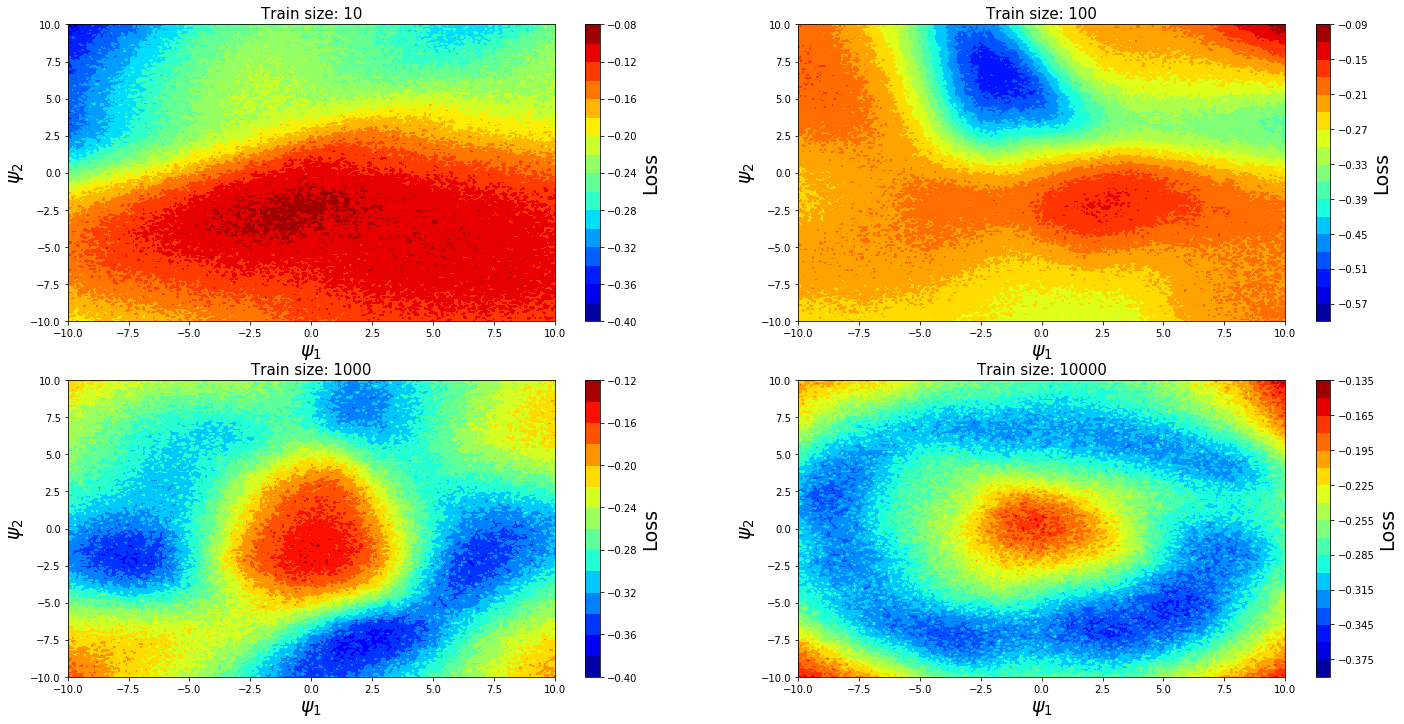

In [16]:
plt.figure(figsize=(24, 12))
for index, key in enumerate(loss_surf):
    plt.subplot(2,2, index + 1)
    plt.contourf(*np.meshgrid(x,y), loss_surf[key].reshape(-1, x.shape[0]).T, cmap=my_cmap, levels=15)
    plt.title(f"Train size: {key.split('_')[0]}", fontsize=15)
    cbar = plt.colorbar()
    plt.xlabel(f"$\psi_1$", fontsize=19)
    plt.ylabel(f"$\psi_2$", fontsize=19)
    cbar.set_label('Loss', rotation=90, fontsize=19)
plt.savefig("plots/loss_surface_as_train.pdf", bbox_inches='tight')              

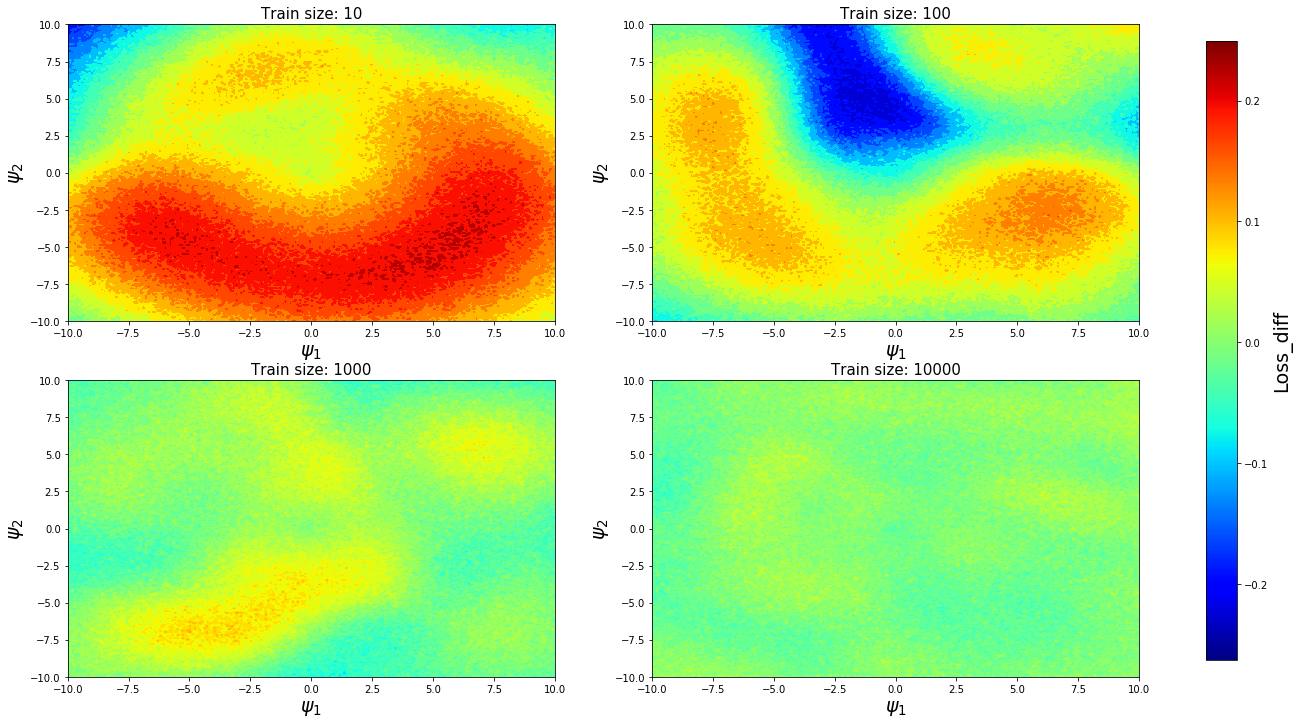

In [18]:
import matplotlib
vmin = 1e11
vmax = -1e12
for index, key in enumerate(loss_surf):
    dummy_data = (loss_surf[key].reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)))
    vmin = min(vmin, dummy_data.min())
    vmax = max(vmax, dummy_data.max())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
for index, key in enumerate(loss_surf):
    ax = axes.flat[index]
    im = ax.contourf(*np.meshgrid(x,y),
                 loss_surf[key].reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)),
                 cmap=my_cmap, levels=15,vmin=vmin, vmax=vmax)
    ax.set_title(f"Train size: {key.split('_')[0]}", fontsize=15)
    ax.set_xlabel(f"$\psi_1$", fontsize=19)
    ax.set_ylabel(f"$\psi_2$", fontsize=19)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)   
sc = matplotlib.cm.ScalarMappable(norm=norm, cmap=my_cmap)
sc._A = []
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.95)
cbar.set_label('Loss_diff', rotation=90, fontsize=19)                 
plt.savefig("plots/diff_surface_as_train.pdf", bbox_inches='tight')

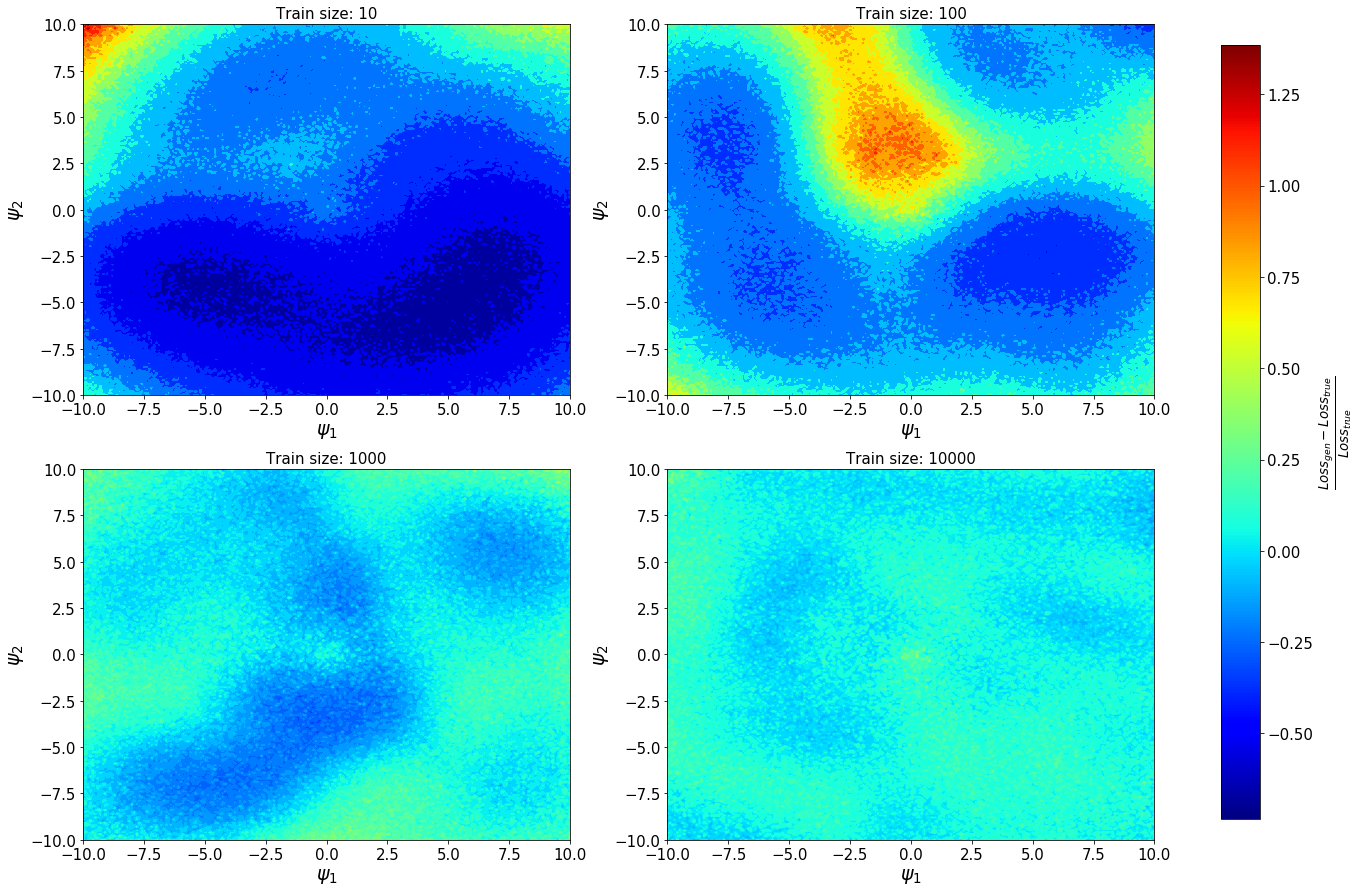

In [20]:
import matplotlib
vmin = 1e11
vmax = -1e12
for index, key in enumerate(loss_surf):
    dummy_data = (loss_surf[key].reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)))/\
            np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0))
    vmin = min(vmin, dummy_data.min())
    vmax = max(vmax, dummy_data.max())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 15))
for index, key in enumerate(loss_surf):
    ax = axes.flat[index]
    
    z_vals = (loss_surf[key].reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)))/\
            np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0))
    im = ax.contourf(*np.meshgrid(x,y),
                 z_vals,
                 cmap=my_cmap, levels=15,vmin=vmin, vmax=vmax)
    ax.set_title(f"Train size: {key.split('_')[0]}", fontsize=15)
    ax.set_xlabel(f"$\psi_1$", fontsize=19)
    ax.set_ylabel(f"$\psi_2$", fontsize=19)
    ax.tick_params(axis="both", labelsize=15)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)   
sc = matplotlib.cm.ScalarMappable(norm=norm, cmap=my_cmap)
sc._A = []
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.95)
cbar.set_label(r'$\frac{Loss_{gen} - Loss_{true}}{Loss_{true}}$', rotation=90, fontsize=19) 
cbar.ax.tick_params(labelsize=15)                  
plt.savefig("diff_surface_relative.pdf", bbox_inches='tight', )

In [99]:
# plt.figure(figsize=(24, 12))
# for index, key in enumerate(loss_surf):
#     plt.subplot(2,2, index + 1)
#     plt.contourf(*np.meshgrid(x,y),
#                  loss_surf[key].reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)),
#                  cmap=my_cmap, levels=15)
#     plt.title(f"Train size: {key.split('_')[0]}", fontsize=15)
#     cbar = plt.colorbar()
#     plt.xlabel(f"$\psi_1$", fontsize=19)
#     plt.ylabel(f"$\psi_2$", fontsize=19)
#     cbar.set_label('Loss', rotation=90, fontsize=19)
# #plt.savefig("plots/diff_surface_as_train.svg")

# Train data parameter space

In [55]:
train_datasets = []
for exp in comet_api.get("shir994/2d-convergence/"):
    hyper_params = {}
    for param in exp.parameters:
        hyper_params[param["name"]] = param["valueMin"]
    if hyper_params['num_epochs'] != '1000' or\
       hyper_params['TASK'] != '5' or\
       ['1000_iter', '20size'] != exp.tags:
        continue
    

    asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] ==
                "train_inputs.npy"][0]
    train_datasets.append(np.load(io.BytesIO(exp.get_asset(asset_id))))

In [134]:
def find_colors(set_index):
    valcounts = np.unique(train_datasets[set_index][:,:2],axis=0, return_counts=True)
    count_map = {}
    for index in range(len(valcounts[0])):
        count_map[tuple(valcounts[0][index])] = valcounts[1][index]
    return np.apply_along_axis(lambda x: count_map[tuple(x)], 1, train_datasets[set_index][:,:2])    

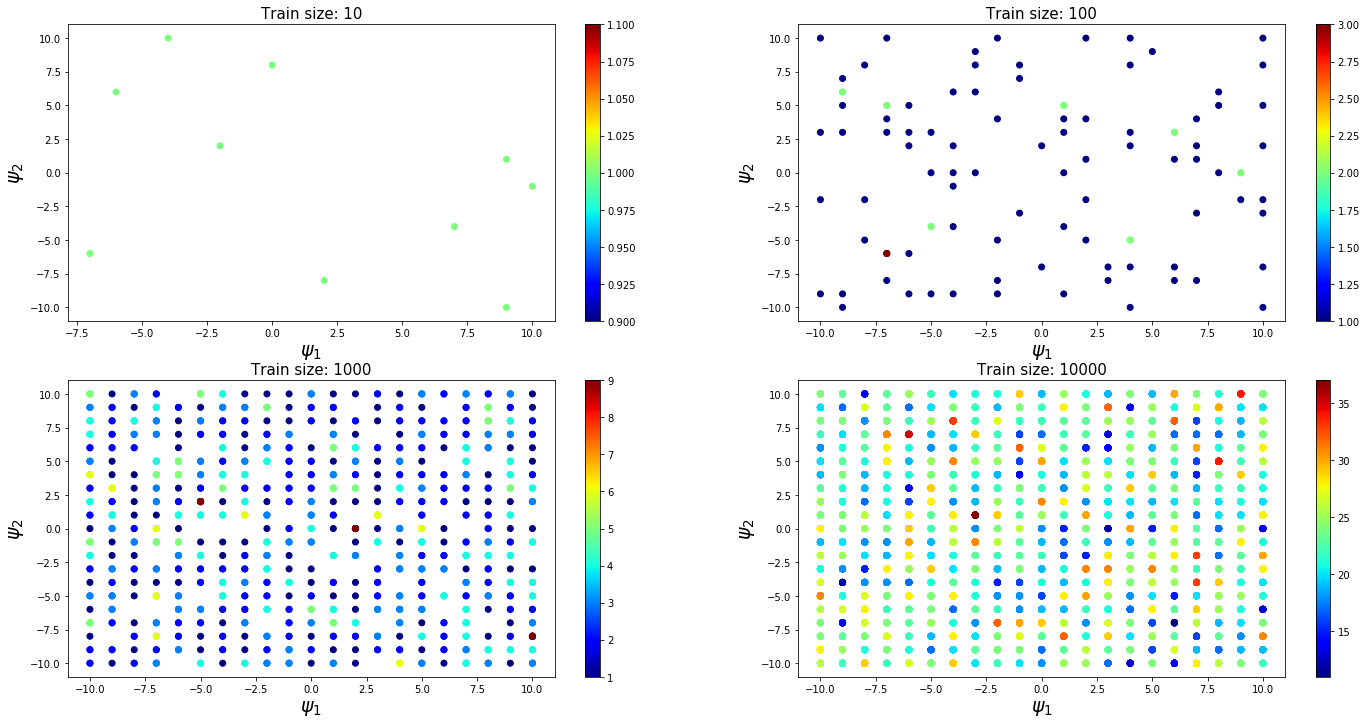

In [137]:
plt.figure(figsize=(24, 12))
for index in range(len(train_datasets)):
    plt.subplot(2,2, index + 1)
    plt.scatter(train_datasets[index][:, 0], train_datasets[index][:, 1], c=find_colors(index), cmap=my_cmap)
    plt.title(f"Train size: {len(train_datasets[index])}", fontsize=15)
    plt.xlabel(f"$\psi_1$", fontsize=19)
    plt.ylabel(f"$\psi_2$", fontsize=19)
    plt.colorbar()
plt.savefig("plots/train_params.pdf", bbox_inches='tight')

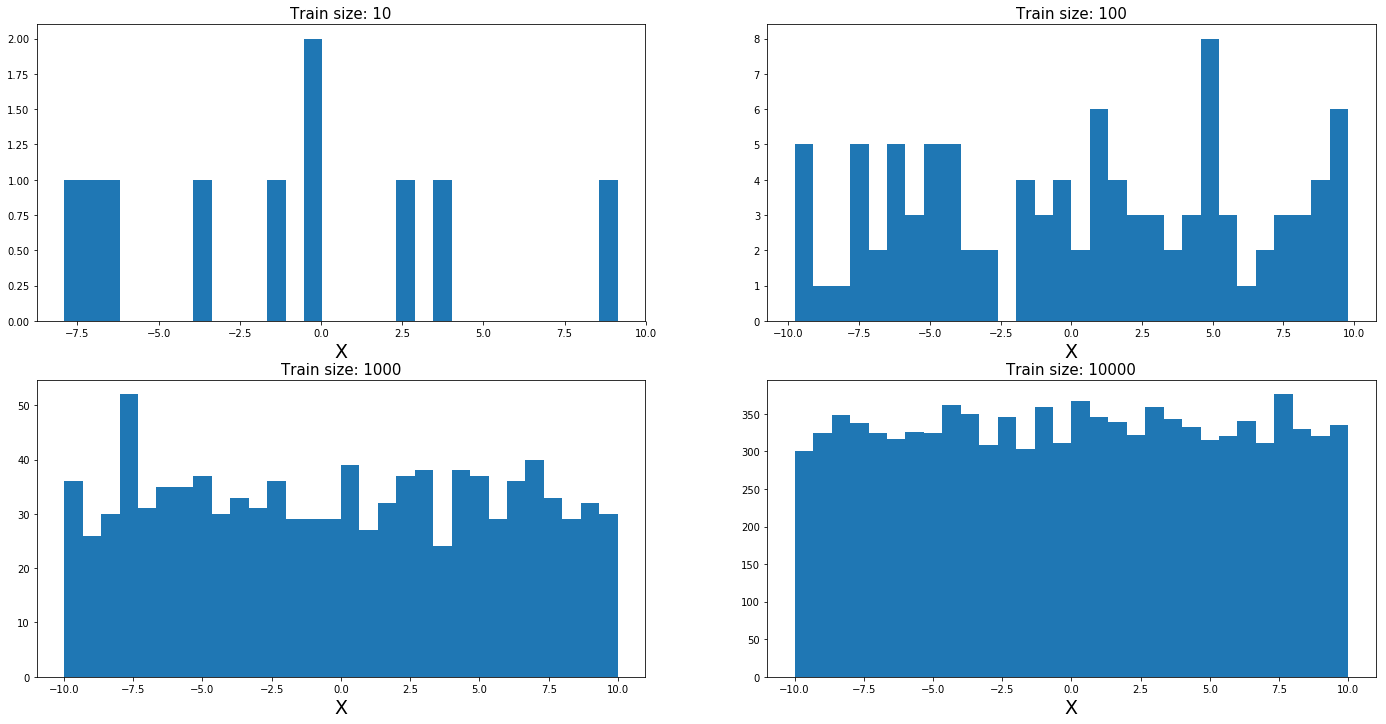

In [61]:
plt.figure(figsize=(24, 12))
for index in range(len(train_datasets)):
    plt.subplot(2,2, index + 1)
    plt.hist(train_datasets[index][:, 2], bins=30)
    plt.title(f"Train size: {len(train_datasets[index])}", fontsize=15)
    plt.xlabel(f"X", fontsize=19)